# Model Interpretability

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import lime.lime_tabular

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

In this notebook we'll explore a random forest model, usually difficult to interpret, with some interpretability metrics.

We'll use:
- Feature Importance
- Partial Dependency
- Global Surrogate Model
- Local Surrogate Model (LIME)

For this we'll use a new dataset, where the classification target is to predict whether someone is or isn't looking for a new job.

In [8]:
df = pd.read_csv("./data/hr_new_job_processed.csv")

target = 'target'
features = df.columns.drop(target).to_list()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 12)

black_box_model = RandomForestClassifier(random_state = 123, max_depth=25, 
                             max_features=10, n_estimators=100, 
                             bootstrap=True)
# Train the model
black_box_model.fit(X_train, y_train)

y_pred = black_box_model.predict(X_test)

metrics.roc_auc_score(y_test, y_pred)

0.8131250708268802

This shows we have a working model. Now let's explain what is going on.

## Permutation Feature Importance

With permutation feature importance, one specific feature is shuffled randomly. This will of course decrease model performance, but depending on how much, this is an indication of the importance of a feature in the model. A bigger impact on error means a more important.

Sklearn has built in utility functions to help with this.

In [15]:
feature_importances = permutation_importance(
    estimator = black_box_model, 
    X = X_train, 
    y = y_train, 
    n_repeats = 5,
    random_state = 123, 
    n_jobs = 2
    )

len(features), feature_importances.importances.shape, feature_importances.importances

(11,
 (11, 5),
 array([[0.30468326, 0.30109747, 0.30392263, 0.30174943, 0.30479192],
        [0.15527545, 0.15103771, 0.15092904, 0.15190699, 0.15603608],
        [0.18200587, 0.18309247, 0.18537433, 0.18254917, 0.18993806],
        [0.15353689, 0.15114637, 0.15168967, 0.1472346 , 0.1562534 ],
        [0.1201782 , 0.11789634, 0.11561447, 0.11659242, 0.11517983],
        [0.00076062, 0.00065196, 0.00097794, 0.0005433 , 0.0005433 ],
        [0.00206454, 0.00206454, 0.0021732 , 0.00206454, 0.0016299 ],
        [0.00130392, 0.00141258, 0.00141258, 0.00152124, 0.00119526],
        [0.00076062, 0.0005433 , 0.00065196, 0.0005433 , 0.0005433 ],
        [0.00988808, 0.01043138, 0.00988808, 0.01097468, 0.01097468],
        [0.04813648, 0.04857112, 0.04563729, 0.04704988, 0.04900576]]))

Feature importance scores are given for each feature, for each iteration (11 features, 5 iterations).

In [18]:
## HELPER PLOT FUNCTION
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, tick_labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

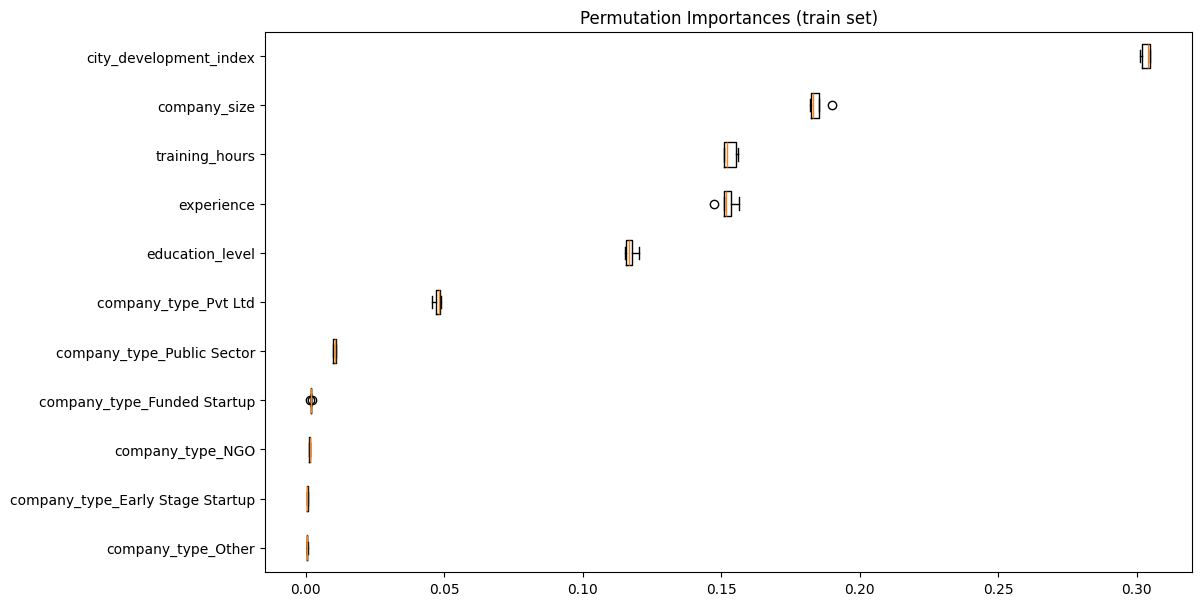

In [19]:
visualize_feature_importance(feature_importances)

From this plot we can clearly see the important features are 'city_development_index', 'company_size', 'training_hours', 'experience' and 'education_level'.

We can easily run more repeats, but no clear difference emerges.

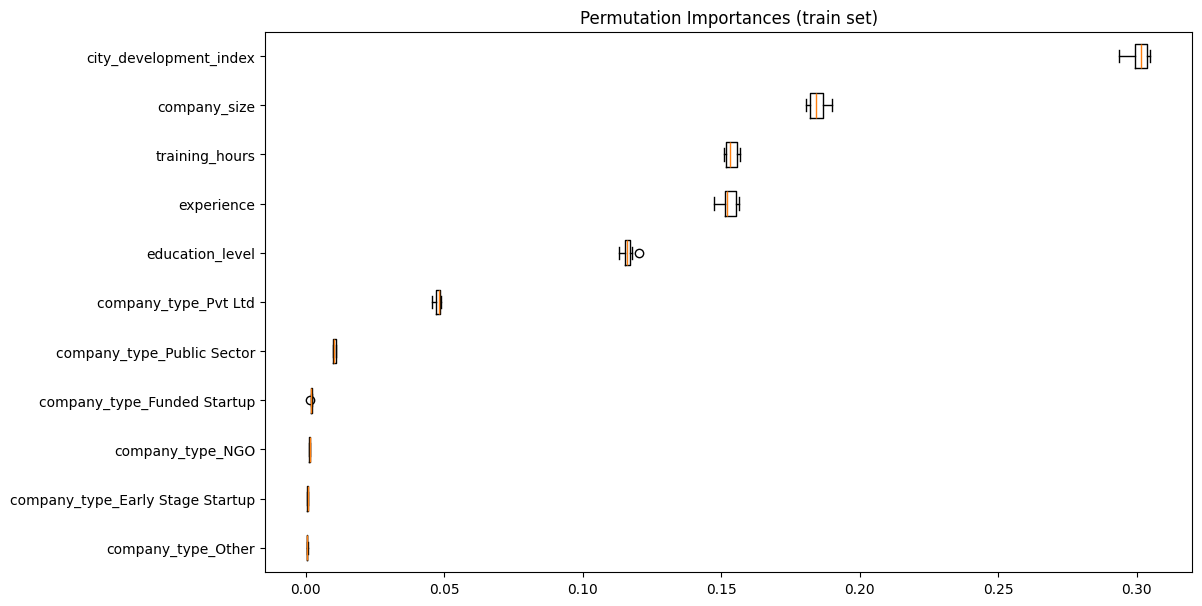

In [20]:
feature_importances = permutation_importance(
    estimator = black_box_model, 
    X = X_train, 
    y = y_train, 
    n_repeats = 10,
    random_state = 123, 
    n_jobs = 2
    )

visualize_feature_importance(feature_importances)

## Partial Dependencey Plot (PDP)

With PDP, we change the distribution of a feature and see how it affects model outcome. Usually this is performed after determining the most important features first, and only on those important features.

Again, sklearn has useful utility functions for this.

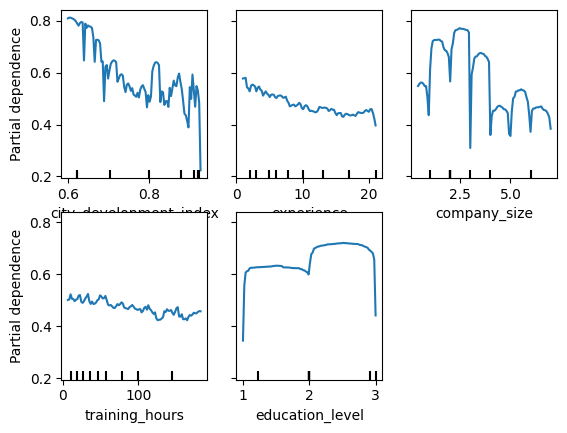

In [24]:
important_features = ['city_development_index', 'experience', 'company_size', 'training_hours', 'education_level']

PartialDependenceDisplay.from_estimator(
    estimator=black_box_model, 
    X=X_train,
    features=important_features, 
    random_state=123
    )

## Global Surrogate Model

Using a Global surrogate model can help with interpretability. In this case we will train two models;
- Logistic Regression
- Decision Tree

In both cases the inputs and output from the original model are used to train this surrogate model. This will be done according to the following steps:
1. Select dataset X_test as input
2. Use the black box model to get $\text{y\_pred}_{bb}$ from X_test
3. Train the surrogate models with this data
4. Surrogate model gives $\text{y\_pred}_{s}$
5. Measure error of the surrogate model to determine how well it performs

With this surrogate model, which is chosen to have more inherent explainability, the idea is to be able to interpret the results of the original model.

In [25]:
min_max_scaler = StandardScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)

lm_surrogate = LogisticRegression(
    max_iter=1000, 
    random_state=123, 
    penalty='l1', 
    solver='liblinear')
lm_surrogate.fit(X_test_minmax, y_pred)

y_surrogate = lm_surrogate.predict(X_test_minmax)

metrics.accuracy_score(y_pred, y_surrogate)

0.7431551499348109

The surrogate model was able to predict about 75% of the black box model. Now we can extract the feature coefficients and interpret how important they are to the result.

In [28]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

In [27]:
coef_dict = get_feature_coefs(lm_surrogate)
coef_dict

{'city_development_index': np.float64(-1.1037003758316433),
 'experience': np.float64(-0.31534600537812607),
 'company_size': np.float64(-0.3102667491190301),
 'company_type_Funded Startup': np.float64(-0.20164083670299643),
 'training_hours': np.float64(-0.1590867045051154),
 'company_type_Early Stage Startup': np.float64(-0.13134779175452335),
 'company_type_NGO': np.float64(-0.052803892359036986),
 'company_type_Other': np.float64(0.07697385537422011),
 'education_level': np.float64(0.1526050373206213),
 'company_type_Pvt Ltd': np.float64(0.4424638344649262)}

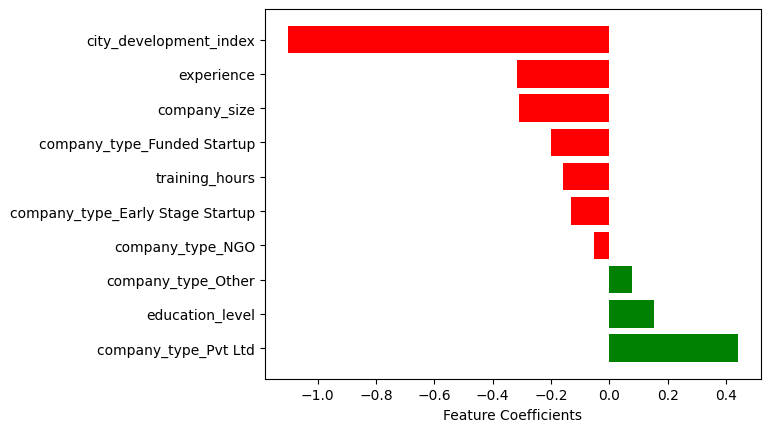

In [29]:
visualize_coefs(coef_dict)

This is already much more insightful than having a bunch of decision trees that don't show how the decision is made.

Let's now use a simple decision tree as a surrogate model.

In [31]:
model = DecisionTreeClassifier(max_depth=5, max_features=10, random_state=123)

y_bb = black_box_model.predict(X_test)
model.fit(X_test, y_bb)
y_s = model.predict(X_test)

metrics.accuracy_score(y_bb, y_s)

0.8213820078226858

In [33]:
tree_exp = export_text(model, feature_names=list(X_train.columns))
print(tree_exp)

|--- city_development_index <= 0.70
|   |--- experience <= 20.92
|   |   |--- training_hours <= 304.03
|   |   |   |--- company_type_Funded Startup <= 0.99
|   |   |   |   |--- city_development_index <= 0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- city_development_index >  0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- company_type_Funded Startup >  0.99
|   |   |   |   |--- education_level <= 2.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- education_level >  2.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- training_hours >  304.03
|   |   |   |--- class: 0.0
|   |--- experience >  20.92
|   |   |--- city_development_index <= 0.67
|   |   |   |--- education_level <= 2.07
|   |   |   |   |--- training_hours <= 44.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- training_hours >  44.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- education_level >  2.07
|   |   |   |   |--- company_size <= 6.50
|   |   |   |   |   |--- cla

## Local Interpretable Model-Agnostic Explanations (LIME)

Global models have an inherent issue, in that they are usually simpler than the models they are explaining, so they are not able to capture a lot of the details of the non-interpretable model. For this we can use LIME, which uses instance weighting to create locally interpretable surrogate models.

Below, we create an explainer with LIME and then pass it a training instance. LIME is able to report which features contribute most to this specific instance.

In [35]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    # Set the training dataset to be X_test.values (2-D Numpy array)
    training_data=X_test.values,
    # Set the mode to be classification
    mode='classification',
    # Set class names to be `Not Changing` and `Changing`
    class_names = ['Not Changing', 'Changing'],
    # Set feature names
    feature_names=list(X_train.columns),
    random_state=123,
    verbose=True)

instance_index = 19
selected_instance = X_test.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
8659,0.924,74.0,7.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0


Intercept 0.9292244657555586
Prediction_local [0.48730243]
Right: 0.030869565217391304


p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


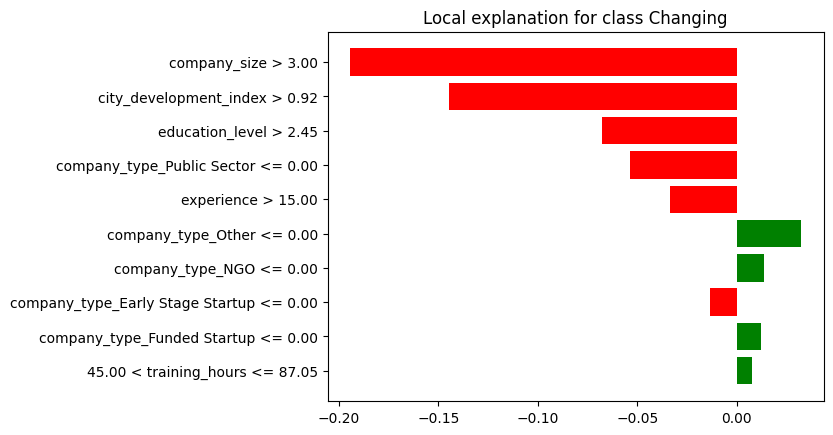

In [36]:
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from black-box model
                                 black_box_model.predict_proba,
                                 # Use max 10 features
                                 num_features=10)
exp.as_pyplot_figure();

From this we can see that the company size being larger than 3.0 is a big impact in this instance. So is the city development index being > 0.92.

The main takeaway is that for this employee, most contributions are very negative, meaning that they are unlikely to be looking for a new job.

## Resources

- [ArXiV - Predictive learning via rule ensembles](https://arxiv.org/abs/0811.1679)
- [ArXiV - A Unified Approach to Interpreting Model Predictions ](https://arxiv.org/abs/1705.07874)
- [ArXiV - Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation](https://arxiv.org/abs/1309.6392)